This notebook is for using ML regression techiques to predict biological age. Currently it has methods for generating age predictions using:
 - Baseline (mean)
 - Multi-Linear regression
 - XGBoost

In [1]:
import boto3
import diff_classifier.aws as aws
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


from os import listdir, getcwd, chdir
from os.path import isfile, join
import os

from matplotlib import colors as plt_colors

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import xgboost as xgb
import shap

In [2]:
!pwd

/Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks


In [4]:
workbookDir = getcwd()
print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/Nance Lab/diff_predictor


In [5]:
dataset_path = workbookDir + '/raw_data_age/'
filelist = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f))]


In [6]:
filelist

['features_P70_40nm_s3_v3.csv',
 'features_P14_40nm_s3_v3.csv',
 'features_P14_40nm_s3_v2.csv',
 'features_P70_40nm_s3_v2.csv',
 'features_P14_40nm_s1_v5.csv',
 'features_P70_40nm_s1_v5.csv',
 'features_P14_40nm_s3_v1.csv',
 'features_P70_40nm_s1_v4.csv',
 'features_P70_40nm_s3_v1.csv',
 'features_P14_40nm_s1_v4.csv',
 'features_P70_40nm_s3_v5.csv',
 '.DS_Store',
 'features_P14_40nm_s3_v5.csv',
 'features_P14_40nm_s3_v4.csv',
 'features_P70_40nm_s1_v1.csv',
 'features_P70_40nm_s3_v4.csv',
 'features_P14_40nm_s1_v1.csv',
 'features_P14_40nm_s1_v3.csv',
 'features_P70_40nm_s1_v3.csv',
 'features_P70_40nm_s1_v2.csv',
 'features_P14_40nm_s1_v2.csv',
 'features_NT_brain_2_slice_1_vid_4.csv',
 'features_P28_40nm_s2_v5.csv',
 'features_P21_40nm_s2_v1.csv',
 'features_P28_40nm_s2_v4.csv',
 'features_NT_brain_2_slice_1_vid_5.csv',
 'features_P21_40nm_s2_v3.csv',
 'features_P21_40nm_s2_v2.csv',
 'features_P28_40nm_s2_v3.csv',
 'features_NT_brain_2_slice_1_vid_2.csv',
 'features_NT_brain_2_slice_

In [7]:
#For regression analysis, want all age groups

fstats_tot = None
video_num = 0
for filename in filelist:
    try:
        fstats = pd.read_csv(dataset_path + filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        print('{} size: {}'.format(filename, fstats.shape))
        if 'P14' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[14], index=fstats.index)
        elif 'P21' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[21], index=fstats.index)
        elif 'P28' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[28], index=fstats.index)
        elif 'NT_brain_2' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[35], index=fstats.index)
        elif 'P70' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[70], index=fstats.index)
        else:
            print('Error, no target')
        fstats['Video Number'] = pd.Series(fstats.shape[0]*[video_num], index=fstats.index)
        if fstats_tot is None:
            fstats_tot = fstats
        else:
            fstats_tot = fstats_tot.append(fstats, ignore_index=True)
        video_num += 1
    except Exception:
            print('Skipped!: {}'.format(filename))

features_P70_40nm_s3_v3.csv size: (2322, 67)
features_P14_40nm_s3_v3.csv size: (323, 91)
features_P14_40nm_s3_v2.csv size: (243, 91)
features_P70_40nm_s3_v2.csv size: (1401, 67)
features_P14_40nm_s1_v5.csv size: (268, 91)
features_P70_40nm_s1_v5.csv size: (17, 67)
features_P14_40nm_s3_v1.csv size: (151, 91)
features_P70_40nm_s1_v4.csv size: (21, 67)
features_P70_40nm_s3_v1.csv size: (2625, 67)
features_P14_40nm_s1_v4.csv size: (140, 91)
features_P70_40nm_s3_v5.csv size: (4162, 67)
Skipped!: .DS_Store
features_P14_40nm_s3_v5.csv size: (389, 91)
features_P14_40nm_s3_v4.csv size: (113, 91)
features_P70_40nm_s1_v1.csv size: (27, 67)
features_P70_40nm_s3_v4.csv size: (2909, 67)
features_P14_40nm_s1_v1.csv size: (793, 91)
features_P14_40nm_s1_v3.csv size: (519, 91)
features_P70_40nm_s1_v3.csv size: (25, 67)
features_P70_40nm_s1_v2.csv size: (12, 67)
features_P14_40nm_s1_v2.csv size: (1356, 91)
features_NT_brain_2_slice_1_vid_4.csv size: (878, 91)
features_P28_40nm_s2_v5.csv size: (372, 91)
f

In [12]:
fstats_tot.head()

,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,...,Mean convex_hull,Std convex_hull,Mean convex_hull_norm,Std convex_hull_norm,Mean dist_tot,Std dist_tot,Mean dist_net,Std dist_net,Mean progression,Std progression
0,0.0,0.300022,1.466714,1.827982,0.831748,0.214532,0.234618,1.377828,0.274220,0.208504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.320179,34.234700,1.986628,0.871043,0.185748,0.268897,1.844000,0.457701,0.169997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,1.724717,0.283085,3.071816,0.997034,0.027251,0.594843,5.022024,0.800877,0.032339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,4.628234,0.000021,1.718922,0.786380,0.244962,0.203225,2.448351,0.591562,0.063546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,1.447265,0.054312,2.213652,0.999969,0.002783,0.682137,15.441644,0.935240,0.015247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


DATA ANALYSIS

In [13]:
fstats_tot.columns


Index(['Track_ID', 'alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2',
       'asymmetry3', 'AR', 'elongation', 'boundedness', 'fractal_dim',
       'trappedness', 'efficiency', 'straightness', 'MSD_ratio', 'frames', 'X',
       'Y', 'Quality', 'Mean_Intensity', 'SN_Ratio', 'Deff1', 'Deff2',
       'Mean alpha', 'Std alpha', 'Mean D_fit', 'Std D_fit', 'Mean kurtosis',
       'Std kurtosis', 'Mean asymmetry1', 'Std asymmetry1', 'Mean asymmetry2',
       'Std asymmetry2', 'Mean asymmetry3', 'Std asymmetry3', 'Mean AR',
       'Std AR', 'Mean elongation', 'Std elongation', 'Mean boundedness',
       'Std boundedness', 'Mean fractal_dim', 'Std fractal_dim',
       'Mean trappedness', 'Std trappedness', 'Mean efficiency',
       'Std efficiency', 'Mean straightness', 'Std straightness',
       'Mean MSD_ratio', 'Std MSD_ratio', 'Mean frames', 'Std frames',
       'Mean X', 'Std X', 'Mean Y', 'Std Y', 'Mean Quality', 'Std Quality',
       'Mean Mean_Intensity', 'Std Mean_Intensity', 'M

In [22]:
fstats_tot
features = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
    'frames', # Number of frames the track spans
    # 'Deff1', # Effective diffusion coefficient at 0.33 s
    # 'Deff2', # Effective diffusion coefficient at 3.3 s
    # 'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    # 'angle_mag_mean', # Magnitude of the turning angle mean
    # 'angle_var', # Variance of the turning angle
    # 'dist_tot', # Total distance of the trajectory
    # 'dist_net', # Net distance from first point to last point
    # 'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1',
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    #'Mean Deff2',
    ]

# shap_features = [
#     'Mean Deff1',
#     'Mean D_fit',
#     'Mean fractal_dim',
#     'Mean MSD_ratio',
#     'Mean kurtosis',
#     'Mean straightness'
#     ]

target = 'age'           # prediction target (y)

ecm = fstats_tot
ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)] 
# Removing nan and inf data points

In [18]:
ecm[features].isna().sum()

alpha                116
D_fit                116
kurtosis               0
asymmetry1             0
asymmetry2             0
asymmetry3             0
AR                     0
elongation             0
boundedness            0
fractal_dim            0
trappedness            0
efficiency             0
straightness           0
MSD_ratio              0
frames                 0
Mean alpha             3
Mean D_fit             3
Mean kurtosis          1
Mean asymmetry1        1
Mean asymmetry2        1
Mean asymmetry3        1
Mean AR                1
Mean elongation        1
Mean boundedness       1
Mean fractal_dim       1
Mean trappedness       1
Mean efficiency        1
Mean straightness      1
Mean MSD_ratio         1
Mean Deff1           627
dtype: int64

In [21]:
def balance_data(df, target, **kwargs):
    if 'random_state' not in kwargs:
        random_state = 1
    else:
        random_state = kwargs['random_state']
    df_target = []
    bal_df = []
    for name in df[target].unique():
        if name > 0: # Needed to do remove nan as a name
            df_target.append((name, df[df[target] == name]))
    print(f"Ratio before data balance ({':'.join([str(i[0]) for i in df_target])}) = {':'.join([str(len(i[1])) for i in df_target])}")
    for i in range(len(df_target)):
        #print(len(df_target[i][1]))
        ratio = min([len(i[1]) for i in df_target])/len(df_target[i][1])
        bal_df.append(df_target[i][1].sample(frac=ratio, random_state=random_state))
    print(f"Ratio after balance ({':'.join([str(i[0]) for i in df_target])}) = {':'.join([str(len(i)) for i in bal_df])}")
    return pd.concat(bal_df)
bal_ecm = balance_data(ecm, target, random_state=1)

Ratio before data balance (70:14:35:28:21) = 14008:6416:17169:6194:20665
Ratio after balance (70:14:35:28:21) = 6194:6194:6194:6194:6194


In [26]:
bal_ecm[features].isna().sum()

alpha                 51
D_fit                 51
kurtosis               0
asymmetry1             0
asymmetry2             0
asymmetry3             0
AR                     0
elongation             0
boundedness            0
fractal_dim            0
trappedness            0
efficiency             0
straightness           0
MSD_ratio              0
frames                 0
Mean alpha             0
Mean D_fit             0
Mean kurtosis          0
Mean asymmetry1        0
Mean asymmetry2        0
Mean asymmetry3        0
Mean AR                0
Mean elongation        0
Mean boundedness       0
Mean fractal_dim       0
Mean trappedness       0
Mean efficiency        0
Mean straightness      0
Mean MSD_ratio         0
Mean Deff1           449
dtype: int64

BINNING OF DATA

In [28]:
resolution = 128
assert not 2048%resolution and resolution >= 128, "resolution needs to be a factor of 2048 and > 128"
bins = list(range(0, 2048+1, resolution))
bin_labels = [int(i/resolution) for i in bins][:-1]
bal_ecm['binx'] = pd.cut(bal_ecm.X, bins, labels=bin_labels, include_lowest=True)
bal_ecm['biny'] = pd.cut(bal_ecm.Y, bins, labels=bin_labels, include_lowest=True)
bal_ecm['bins'] = (len(bins)-1)*bal_ecm['binx'].astype(np.int32) + bal_ecm['biny'].astype(np.int32)
bal_ecm = bal_ecm[np.isfinite(bal_ecm['bins'])]
bal_ecm['bins'] = bal_ecm['bins'].astype(int)

In [29]:
# Regular split of data
seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

#le = preprocessing.LabelEncoder()
#bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

# y_train = X_train['encoded_target']
# y_test = X_test['encoded_target']
# y_val = X_val['encoded_target']

# y_train = X_train['age']
# y_test = X_test['age']
# y_val = X_val['age']

# dtrain = xgb.DMatrix(X_train[features], label=y_train)
# dtest = xgb.DMatrix(X_test[features], label=y_test)
# dval = xgb.DMatrix(X_val[features], label=y_val)

In [30]:
def get_lengths(df, X_train, X_test, X_val=None):
    print(f'Tot before split: {len(df)}')
    print(f'Training: {len(X_train)} ({len(X_train)/len(bal_ecm):.3f}%)')
    print(f'Testing: {len(X_test)} ({len(X_test)/len(bal_ecm):.3f}%)')
    try:
        print(f'Evaluation: {len(X_val)} ({len(X_val)/len(bal_ecm):.3f}%)')
    except:
        pass
get_lengths(bal_ecm, X_train, X_test, X_val)

Tot before split: 30970
Training: 15619 (0.504%)
Testing: 7676 (0.248%)
Evaluation: 7675 (0.248%)


BASELINE PREDICTIONS

In [31]:
# Build Baseline Model
mean_train = y_train.mean() # Mean of training data
baseline_predictions = np.ones(y_test.shape) * mean_train #baseline predictions using mean
mae_baseline = metrics.mean_absolute_error(y_true=y_test, y_pred=baseline_predictions)
mse_baseline = metrics.mean_squared_error(y_true=y_test, y_pred=baseline_predictions)
baseline_r2_score = metrics.r2_score(y_true=y_test, y_pred=baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))
print("Baseline MSE is {:.2f}".format(mse_baseline))
#print("Baseline R2 score is {:.2f}".format(baseline_r2_score))

NameError: name 'y_train' is not defined

PREDICTIONS WITH LINEAR REGRESSION 

In [1]:

linear_columns = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
    'frames', # Number of frames the track spans
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1',
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'age'
    ]

linear_features = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
    'frames', # Number of frames the track spans
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1',
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1'
    ]
# for linear regression
#ss = preprocessing.StandardScaler()

train_lin = X_train[linear_columns]
train_lin = train_lin.dropna()
#scaled_train_lin = ss.fit_transform(train_lin) #scale training data
test_lin = X_test_val[linear_columns]
test_lin = test_lin.dropna()
#scaled_test_lin = ss.fit_transform(test_lin) #scale test data with same mean and stdev as training data

# For XGBoost

# XGB_train = X_train[linear_columns]
# XGB_test = X_test[lin]
y_train = X_train['age']
y_test = X_test['age']
y_val = X_val['age']

dtrain = xgb.DMatrix(X_train[linear_features], label=y_train)
dtest = xgb.DMatrix(X_test[linear_features], label=y_test)
dval = xgb.DMatrix(X_val[linear_features], label=y_val)

NameError: name 'X_train' is not defined

In [8]:
from itertools import combinations

input = ['a', 'b', 'c', 'd']

output = sum([list(map(list, combinations(input, i))) for i in range(2, len(input) + 1)], [])
for subset in output:
    print(subset)

['a', 'b']
['a', 'c']
['a', 'd']
['b', 'c']
['b', 'd']
['c', 'd']
['a', 'b', 'c']
['a', 'b', 'd']
['a', 'c', 'd']
['b', 'c', 'd']
['a', 'b', 'c', 'd']


In [33]:
def get_linear_preds(model, train_df, test_df, features, target_name):
    """
    This function creates a linear regression based on the model_type parameter,
    and gets training and testing predictions on the passed dataframes. 

    Parameters:
    ----------
    model_type: Takes a string to specify which linear model to use. Can be either 
                'Linear,' 'Lasso,' or 'Ridge.' If none are given, tells user to specifiy 
                which model type to use
    train_df: dataframe for training data. Should include both features and target columns
    test_df: dataframe for training data. Should include both features and target columns
    features: List of features to be using for training the model. Should be the names of
              columns in passed dataframes
    target_name: name of column header for target variable. Should be string

    Returns:
    --------
    train_preds: predictions on training features
    test_preds: predictons on testing features
    statistics: dictionary of error statistic for testing and training predictons
    """
    X_train = train_df[features]
    y_train = train_df[target_name]
    X_test = test_df[features]
    y_test = test_df[target_name]

    ss = preprocessing.StandardScaler()
    scaled_X_train = ss.fit_transform(X_train)
    scaled_X_test = ss.fit_transform(X_test)

    # Fit model
    model.fit(scaled_X_train, y_train)

    # Get predictions on training data
    train_preds = model.predict(scaled_X_train)
    train_mse = metrics.mean_squared_error(y_true=y_train, y_pred=train_preds)
    train_mae = metrics.mean_absolute_error(y_true=y_train, y_pred=train_preds)
    train_r2 = metrics.r2_score(y_true=y_train, y_pred=train_preds)

    # Predict on test data
    test_preds = model.predict(scaled_X_test)
    test_mse = metrics.mean_squared_error(y_true=y_test, y_pred=test_preds)
    test_mae = metrics.mean_absolute_error(y_true=y_test, y_pred=test_preds)
    test_r2 = metrics.r2_score(y_true=y_test, y_pred=test_preds)

    statistics = {
            'Training MSE': train_mse,
            'Training MAE': train_mae,
            'Training r2 Score': train_r2,
            'Test MSE': test_mse,
            'Test MAE': test_mae,
            'Test r2 Score': test_r2
    }
    
    return train_preds, test_preds, statistics

In [34]:
lin_reg = LinearRegression()
lin_train_preds, lin_test_preds, lin_stats = get_linear_preds(lin_reg, train_lin, test_lin, linear_features, 'age')
print(lin_stats)

{'Training MSE': 178.21247109713232, 'Training MAE': 10.721950867862152, 'Training r2 Score': 0.5292211562133802, 'Test MSE': 175.7203582275633, 'Test MAE': 10.575171980674634, 'Test r2 Score': 0.5450530587713596}


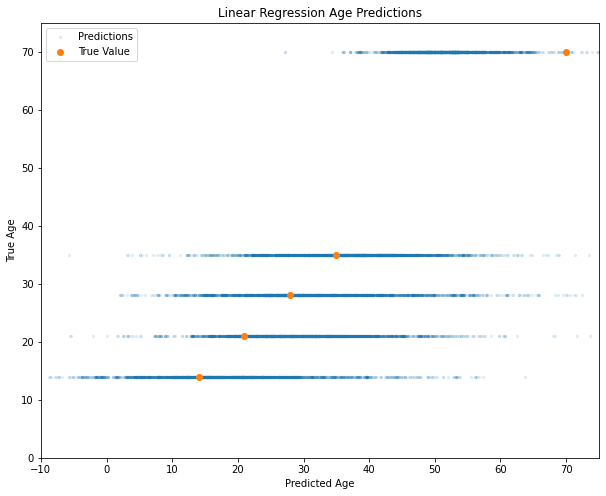

In [40]:
plt.figure(figsize=(10,8))
plt.scatter(y=test_lin['age'], x=rr_test_preds, Label='Predictions', alpha=0.1, s=5)
plt.scatter(y=[14, 21, 28, 35, 70], x=[14, 21, 28, 35, 70], Label='True Value')
plt.ylabel('True Age')
plt.xlabel('Predicted Age')
plt.title('Linear Regression Age Predictions')
plt.legend(loc='upper left')
plt.ylim(0,75)
plt.xlim(-10,75)
plt.show()

In [37]:
rr_model = Ridge()
rr_train_preds, rr_test_preds, rr_stats = get_linear_preds(rr_model, train_lin, test_lin, linear_features, 'age')
print(rr_stats)

{'Training MSE': 178.57535075163563, 'Training MAE': 10.754699489728488, 'Training r2 Score': 0.5282625472948851, 'Test MSE': 175.86349210544478, 'Test MAE': 10.596260984975032, 'Test r2 Score': 0.5446824795135821}


In [38]:
las_model = Lasso()
las_train_preds, las_test_preds, las_stats = get_linear_preds(las_model, train_lin, test_lin, linear_features, 'age')
print(las_stats)


{'Training MSE': 184.9927635193413, 'Training MAE': 10.942368326761642, 'Training r2 Score': 0.5113098495163142, 'Test MSE': 183.65598447320264, 'Test MAE': 10.829741777225966, 'Test r2 Score': 0.5245074092882651}


In [39]:
alpha_val = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for val in alpha_val:
    model = Ridge(alpha=val)
    train_pred,  test_pred, stats = get_linear_preds(model, train_lin, test_lin, linear_features, 'age')
    print('MAE: ', stats['Test MAE'])

MAE:  10.575174816255705
MAE:  10.575200344726026
MAE:  10.575453181621148
MAE:  10.577986959587736
MAE:  10.596260984975032
MAE:  10.629209762524573
MAE:  10.642958587617997
MAE:  10.709141055586441


In [96]:
# Set initial parameters
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'reg:linear',
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mae"
        }

In [97]:
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException

def cv(params, X_train, y_train, features=None, num_boost_round=20, nfold=3, stratified=False, folds=None,
       metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None,
       fpreproc=None, as_pandas=True, verbose_eval=100, show_stdv=True,
       seed=0, callbacks=None, shuffle=True):
    # pylint: disable = invalid-name
    """Cross-validation with given parameters.

    Parameters
    ----------
    params : dict
        Booster params.
    dtrain : DMatrix
        Data to be trained.
    num_boost_round : int
        Number of boosting iterations.
    nfold : int
        Number of folds in CV.
    stratified : bool
        Perform stratified sampling.
    folds : a KFold or StratifiedKFold instance or list of fold indices
        Sklearn KFolds or StratifiedKFolds object.
        Alternatively may explicitly pass sample indices for each fold.
        For ``n`` folds, **folds** should be a length ``n`` list of tuples.
        Each tuple is ``(in,out)`` where ``in`` is a list of indices to be used
        as the training samples for the ``n`` th fold and ``out`` is a list of
        indices to be used as the testing samples for the ``n`` th fold.
    metrics : string or list of strings
        Evaluation metrics to be watched in CV.
    obj : function
        Custom objective function.
    feval : function
        Custom evaluation function.
    maximize : bool
        Whether to maximize feval.
    early_stopping_rounds: int
        Activates early stopping. Cross-Validation metric (average of validation
        metric computed over CV folds) needs to improve at least once in
        every **early_stopping_rounds** round(s) to continue training.
        The last entry in the evaluation history will represent the best iteration.
        If there's more than one metric in the **eval_metric** parameter given in
        **params**, the last metric will be used for early stopping.
    fpreproc : function
        Preprocessing function that takes (dtrain, dtest, param) and returns
        transformed versions of those.
    as_pandas : bool, default True
        Return pd.DataFrame when pandas is installed.
        If False or pandas is not installed, return np.ndarray
    verbose_eval : bool, int, or None, default None
        Whether to display the progress. If None, progress will be displayed
        when np.ndarray is returned. If True, progress will be displayed at
        boosting stage. If an integer is given, progress will be displayed
        at every given `verbose_eval` boosting stage.
    show_stdv : bool, default True
        Whether to display the standard deviation in progress.
        Results are not affected, and always contains std.
    seed : int
        Seed used to generate the folds (passed to numpy.random.seed).
    callbacks : list of callback functions
        List of callback functions that are applied at end of each iteration.
        It is possible to use predefined callbacks by using
        :ref:`Callback API <callback_api>`.
        Example:

        .. code-block:: python

            [xgb.callback.reset_learning_rate(custom_rates)]
    shuffle : bool
        Shuffle data before creating folds.

    Returns
    -------
    evaluation history : list(string)
    """
    if stratified is True and not SKLEARN_INSTALLED:
        raise XGBoostError('sklearn needs to be installed in order to use stratified cv')
    if isinstance(metrics, str):
        metrics = [metrics]
    if not features:
        features = X_train.columns
    if isinstance(params, list):
        _metrics = [x[1] for x in params if x[0] == 'eval_metric']
        params = dict(params)
        if 'eval_metric' in params:
            params['eval_metric'] = _metrics
    else:
        params = dict((k, v) for k, v in params.items())
    if (not metrics) and 'eval_metric' in params:
        if isinstance(params['eval_metric'], list):
            metrics = params['eval_metric']
        else:
            metrics = [params['eval_metric']]
    params.pop("eval_metric", None)
    results = {}
    # create folds in data
    cvfolds, wt_list = mknfold(X_train, y_train, nfold, params, metrics, features)
    
    # setup callbacks
    callbacks = [] if callbacks is None else callbacks
    if early_stopping_rounds is not None:
        callbacks.append(callback.early_stop(early_stopping_rounds,
                                             maximize=maximize,
                                             verbose=False))
    if isinstance(verbose_eval, bool) and verbose_eval:
        callbacks.append(callback.print_evaluation(show_stdv=show_stdv))
    elif isinstance(verbose_eval, int):
        callbacks.append(callback.print_evaluation(verbose_eval, show_stdv=show_stdv))
    callbacks_before_iter = [
        cb for cb in callbacks if
        cb.__dict__.get('before_iteration', False)]
    callbacks_after_iter = [
        cb for cb in callbacks if
        not cb.__dict__.get('before_iteration', False)]
    for i in range(num_boost_round):
        for cb in callbacks_before_iter:
            cb(CallbackEnv(model=None,
                           cvfolds=cvfolds,
                           iteration=i,
                           begin_iteration=0,
                           end_iteration=num_boost_round,
                           rank=0,
                           evaluation_result_list=None))
        for fold in cvfolds:
            fold.update(i, obj)
        res = aggcv([f.eval(i, feval) for f in cvfolds], wt_list)
        for key, mean, std in res:
            if key + '-mean' not in results:
                results[key + '-mean'] = []
            if key + '-std' not in results:
                results[key + '-std'] = []
            results[key + '-mean'].append(mean)
            results[key + '-std'].append(std)
        try:
            for cb in callbacks_after_iter:
                cb(CallbackEnv(model=None,
                               cvfolds=cvfolds,
                               iteration=i,
                               begin_iteration=0,
                               end_iteration=num_boost_round,
                               rank=0,
                               evaluation_result_list=res))
        except EarlyStopException as e:
            for k in results:
                results[k] = results[k][:(e.best_iteration + 1)]
            break
    
    if as_pandas:
        try:
            import pandas as pd
            results = pd.DataFrame.from_dict(results)
        except ImportError:
            pass
    return results

In [98]:
def bin_fold(X_train, nfold):
    bin_list = [X_train[X_train['bins'] == i_bin].index.to_numpy() for i_bin in X_train.bins.unique()]
    bin_list = sorted(bin_list, key=len)
    i = 0
    while(len(bin_list) > nfold):
        if (i >= len(bin_list)-1):
            i = 0
        bin_list[i] = np.concatenate([bin_list[i], bin_list.pop()])
        i += 1
    wt_list = [len(i)/sum(len(s) for s in bin_list) for i in bin_list]
    return bin_list, wt_list

def mknfold(X_train, y_train, nfold, param, evals=(), features=None):
    if not features:
        features = X_train.columns
    dall = xgb.DMatrix(X_train[features], label=y_train)
    out_idset, wt_list = bin_fold(X_train, nfold)
    in_idset = [np.concatenate([out_idset[i] for i in range(nfold) if k != i]) for k in range(nfold)]
    evals = list(evals)
    ret = []
    for k in range(nfold):
        # perform the slicing using the indexes determined by the above methods
        x_train_snip = X_train.loc[in_idset[k]][features]
        y_train_snip = X_train.loc[in_idset[k]]['age']        
        x_test_snip = X_train.loc[out_idset[k]][features]
        y_test_snip = X_train.loc[out_idset[k]]['age']
        dtrain = xgb.DMatrix(x_train_snip, label=y_train_snip)
        dtest = xgb.DMatrix(x_test_snip, label=y_test_snip)
        tparam = param
        plst = list(tparam.items()) + [('eval_metric', itm) for itm in evals]
        ret.append(CVPack(dtrain, dtest, plst))
    return ret, wt_list

In [99]:
from xgboost.core import STRING_TYPES

def aggcv(rlist, wt_list):
    # pylint: disable=invalid-name
    """
    Aggregate cross-validation results.

    If verbose_eval is true, progress is displayed in every call. If
    verbose_eval is an integer, progress will only be displayed every
    `verbose_eval` trees, tracked via trial.
    """
    cvmap = {}
    idx = rlist[0].split()[0]
    for line in rlist:
        arr = line.split()
        assert idx == arr[0]
        for metric_idx, it in enumerate(arr[1:]):
            if not isinstance(it, STRING_TYPES):
                it = it.decode()
            k, v = it.split(':')
            if (metric_idx, k) not in cvmap:
                cvmap[(metric_idx, k)] = []
            cvmap[(metric_idx, k)].append(float(v))
    msg = idx
    results = []
    for (metric_idx, k), v in sorted(cvmap.items(), key=lambda x: x[0][0]):
        v = np.array(v)
        if not isinstance(msg, STRING_TYPES):
            msg = msg.decode()
        mean = np.average(v, weights=wt_list)
        std = np.average((v-mean)**2, weights=wt_list)
        results.extend([(k, mean, std)])
    return results

In [ ]:
cv_results = cv(param, X_train, y_train, features, num_boost_round=2000, nfold=5, early_stopping_rounds=200, metrics={'rmse'})
cv_results

In [100]:
import operator
import numpy as np

def xgb_paramsearch(X_train, y_train, features, init_params, nfold=5, num_boost_round=2000, early_stopping_rounds=3, metrics=None, **kwargs):
    params = {**init_params}
    if 'use_gpu' in kwargs and kwargs['use_gpu']:
        # GPU integration will cut cv time in ~half:
        params.update({'gpu_id' : 0,
                       'tree_method': 'gpu_hist',
                       'predictor': 'gpu_predictor'})
    if 'metrics' not in kwargs:
        metrics = {params['eval_metric']}
    else:
        metrics.add(params['eval_metric'])
    if params['eval_metric'] in ['map', 'auc', 'aucpr']:
        eval_f = operator.gt
    else: 
        eval_f = operator.lt
    if 'early_break' not in kwargs:
        early_break = 5
    else: 
        early_break = kwargs['early_break']
    if 'thresh' not in kwargs:
        thresh = 0.01
    else: 
        thresh = kwargs['thresh']
    if 'seed' not in kwargs:
        seed = 1111
    else:
        seed = kwargs['seed']
    best_param = params
    best_model = cv(params, 
                    X_train, 
                    y_train, 
                    features, 
                    nfold=nfold, 
                    num_boost_round=num_boost_round, 
                    early_stopping_rounds=early_stopping_rounds, 
                    metrics=metrics)
    best_eval = best_model[f"test-{params['eval_metric']}-mean"].min()
    best_boost_rounds = best_model[f"test-{params['eval_metric']}-mean"].idxmin()
    
    def _gs_helper(var1n, var2n, best_model, best_param, best_eval, best_boost_rounds):
        local_param = {**best_param}
        for var1, var2 in gs_params:
            print(f"Using CV with {var1n}={{{var1}}}, {var2n}={{{var2}}}")
            local_param[var1n] = var1
            local_param[var2n] = var2
            cv_model = cv(local_param, 
                          X_train, 
                          y_train, 
                          features, 
                          nfold=nfold, 
                          num_boost_round= num_boost_round, 
                          early_stopping_rounds=early_stopping_rounds, 
                          metrics=metrics)
            cv_eval = cv_model[f"test-{local_param['eval_metric']}-mean"].min()
            boost_rounds = cv_model[f"test-{local_param['eval_metric']}-mean"].idxmin()
            if(eval_f(cv_eval, best_eval)):
                best_model = cv_model
                best_param[var1n] = var1
                best_param[var2n] = var2
                best_eval = cv_eval
                best_boost_rounds = boost_rounds
                print(f"New best param found: "
                      f"{local_param['eval_metric']} = {{{best_eval}}}, "
                      f"boost_rounds = {{{best_boost_rounds}}}")
        return best_model, best_param, best_eval, best_boost_rounds
    
    while(early_break >= 0):
        np.random.seed(seed)
        best_eval_init = best_eval
        gs_params = {
            (subsample, colsample)
            for subsample in np.random.choice([i/10. for i in range(5,11)], 3)
            for colsample in np.random.choice([i/10. for i in range(5,11)], 3)
        }
        best_model, best_param, best_eval, best_boost_rounds = _gs_helper('subsample', 
                                                                          'colsample_bytree', 
                                                                          best_model, 
                                                                          best_param, 
                                                                          best_eval, 
                                                                          best_boost_rounds)
        gs_params = {
            (max_depth, min_child_weight)
            for max_depth in [10] + list(np.random.randint(1, 10, 3))
            for min_child_weight in [0, 10] + list(np.random.randint(0, 10, 3))
        }
        best_model, 
        best_param, 
        best_eval, 
        best_boost_rounds = _gs_helper('max_depth', 
                                                                          'min_child_weight', 
                                                                          best_model, 
                                                                          best_param, 
                                                                          best_eval, 
                                                                          best_boost_rounds)
        gs_params = {
            (eta, gamma)
            for eta in np.random.choice([.005, .01, .05, .1, .2, .3], 3)
            for gamma in [0] + list(np.random.choice([0.01, 0.001, 0.2, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0], 3))
        }
        best_model, best_param, best_eval, best_boost_rounds = _gs_helper('eta', 
                                                                          'gamma', 
                                                                          best_model, 
                                                                          best_param, 
                                                                          best_eval, 
                                                                          best_boost_rounds)
        if (abs(best_eval_init - best_eval) < thresh):
            early_break-=1
        seed+=1
    return best_model, best_param, best_eval, best_boost_rounds


In [122]:
best_model, best_param, best_eval, best_boost_rounds = xgb_paramsearch(X_train, y_train, linear_features, init_params=last_params, nfold=5, num_boost_round=2000, early_stopping_rounds=3, metrics={'mae', 'merror'})

rmse:5.86058+0.00627	test-rmse:6.43013+0.05994
[400]	train-rmse:5.63063+0.00672	test-rmse:6.32375+0.06286
Using CV with eta={0.01}, gamma={0.01}
[0]	train-rmse:24.90393+0.00242	test-rmse:24.89746+0.04073
[100]	train-rmse:10.77869+0.00050	test-rmse:10.92904+0.05039
[200]	train-rmse:6.73902+0.00397	test-rmse:7.12848+0.05295
[300]	train-rmse:5.86058+0.00627	test-rmse:6.43013+0.05994
[400]	train-rmse:5.63063+0.00672	test-rmse:6.32375+0.06286
Using CV with eta={0.005}, gamma={5.0}
[0]	train-rmse:25.02137+0.00242	test-rmse:25.01431+0.04092
[100]	train-rmse:15.98385+0.00047	test-rmse:16.03426+0.04570
[200]	train-rmse:10.83564+0.00063	test-rmse:10.97878+0.04964
[300]	train-rmse:8.09295+0.00253	test-rmse:8.35256+0.05174
[400]	train-rmse:6.75656+0.00424	test-rmse:7.13526+0.05470
[500]	train-rmse:6.14555+0.00520	test-rmse:6.62102+0.05925
[600]	train-rmse:5.86243+0.00564	test-rmse:6.41934+0.06254
[700]	train-rmse:5.71736+0.00577	test-rmse:6.34380+0.06364
[800]	train-rmse:5.62897+0.00616	test-rmse:

In [123]:
best_param

{'max_depth': 4,
 'eta': 0.005,
 'min_child_weight': 5,
 'verbosity': 0,
 'objective': 'reg:linear',
 'silent': 'True',
 'gamma': 5.0,
 'subsample': 0.15,
 'colsample_bytree': 0.8,
 'eval_metric': 'rmse'}

In [32]:
linear_best_param = {'max_depth': 4,
 'eta': 0.005,
 'min_child_weight': 5,
 'verbosity': 0,
 'objective': 'reg:linear',
 'silent': 'True',
 'gamma': 5.0,
 'subsample': 0.15,
 'colsample_bytree': 0.8,
 'eval_metric': 'rmse'}

In [124]:
last_params

{'max_depth': 10,
 'eta': 0.005,
 'min_child_weight': 10,
 'verbosity': 0,
 'objective': 'reg:linear',
 'silent': 'True',
 'gamma': 5.0,
 'subsample': 0.15,
 'colsample_bytree': 0.8,
 'eval_metric': 'rmse'}

In [126]:
best_boost_rounds

(     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
 0          25.021365        0.002424       25.014308       0.040919
 1          24.905162        0.002368       24.898965       0.041316
 2          24.789092        0.002386       24.783403       0.041167
 3          24.673541        0.002364       24.668227       0.041091
 4          24.558589        0.002397       24.553282       0.040730
 ..               ...             ...             ...            ...
 874         5.579041        0.006425        6.305294       0.065285
 875         5.578308        0.006423        6.305151       0.065309
 876         5.577830        0.006407        6.305072       0.065360
 877         5.577394        0.006403        6.305158       0.065354
 878         5.577001        0.006388        6.305000       0.065314
 
 [879 rows x 4 columns],
 {'max_depth': 4,
  'eta': 0.005,
  'min_child_weight': 5,
  'verbosity': 0,
  'objective': 'reg:linear',
  'silent': 'True',
  'gamma': 5.0,
  '

In [33]:
last_params = {'max_depth': 10,
 'eta': 0.005,
 'min_child_weight': 10,
 'verbosity': 0,
 'objective': 'reg:linear',
 'silent': 'True',
 'gamma': 5.0,
 'subsample': 0.15,
 'colsample_bytree': 0.8,
 'eval_metric': 'rmse'}

In [34]:
best_boost_rounds=879

In [ ]:
cv_results['test-mae-mean'].min()

In [ ]:
cv_results['train-mae-mean'].min()

In [35]:

def train(param, dtrain, dtest, num_round, dval=None, evals=[(dtrain, 'train')]):
    if dval is not None and (dval, 'eval') not in evals:
        evals += [(dval, 'eval')]
    model = xgb.train(param, dtrain, num_round, evals)
    return model

booster = train(linear_best_param, dtrain, dtest, best_boost_rounds, dval, evals=[(dtrain, 'train'), (dval, 'eval')])




	eval-rmse:13.55371
[435]	train-rmse:12.86120	eval-rmse:13.54567
[436]	train-rmse:12.85236	eval-rmse:13.53652
[437]	train-rmse:12.84341	eval-rmse:13.52824
[438]	train-rmse:12.83452	eval-rmse:13.51994
[439]	train-rmse:12.82452	eval-rmse:13.51096
[440]	train-rmse:12.81457	eval-rmse:13.50250
[441]	train-rmse:12.80501	eval-rmse:13.49423
[442]	train-rmse:12.79518	eval-rmse:13.48553
[443]	train-rmse:12.78473	eval-rmse:13.47534
[444]	train-rmse:12.77536	eval-rmse:13.46651
[445]	train-rmse:12.76779	eval-rmse:13.45887
[446]	train-rmse:12.75849	eval-rmse:13.45032
[447]	train-rmse:12.74863	eval-rmse:13.44077
[448]	train-rmse:12.73987	eval-rmse:13.43241
[449]	train-rmse:12.73198	eval-rmse:13.42499
[450]	train-rmse:12.72432	eval-rmse:13.41716
[451]	train-rmse:12.71603	eval-rmse:13.40998
[452]	train-rmse:12.70815	eval-rmse:13.40261
[453]	train-rmse:12.69951	eval-rmse:13.39401
[454]	train-rmse:12.69106	eval-rmse:13.38593
[455]	train-rmse:12.68288	eval-rmse:13.37797
[456]	train-rmse:12.67476	eval-rmse

In [38]:
true_label = dtest.get_label()
ypred = booster.predict(dtest)
#preds = [np.where(x == np.max(x))[0][0] for x in ypred]
mse_model = metrics.mean_squared_error(true_label, ypred)
mae_model = metrics.median_absolute_error(true_label, ypred)
print("mean squared error:", mse_model)
#print(" - improvement from baseline: ", (mse_model - mse_baseline))
print("mean absolute error", mae_model)
#print(" - improvement from baseline: ", (mae_model -mae_baseline))

mean squared error: 153.4516
mean absolute error 7.3940544


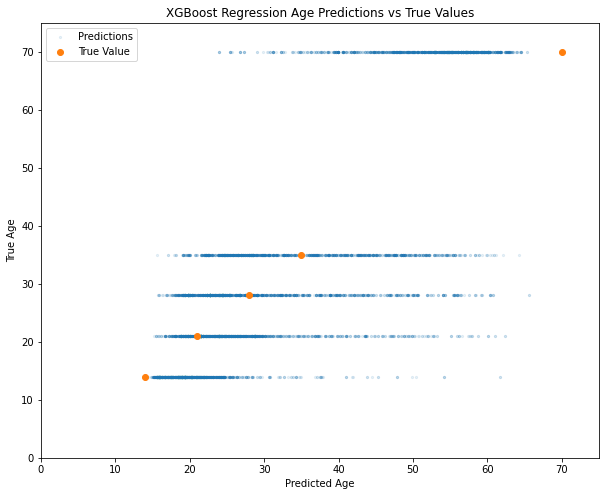

In [37]:
plt.figure(figsize=(10,8))
plt.scatter(y=true_label, x=ypred, Label='Predictions', alpha=0.1, s=5)
plt.scatter(y=[14, 21, 28, 35, 70], x=[14, 21, 28, 35, 70], Label='True Value')
plt.ylabel('True Age')
plt.xlabel('Predicted Age')
plt.title('XGBoost Regression Age Predictions vs True Values')
plt.legend(loc='upper left')
plt.ylim(0,75)
plt.xlim(0,75)
plt.show()

In [135]:
explainer = shap.TreeExplainer(booster) #using booster instead of bst
shap_values = explainer.shap_values(X_test[linear_features])
shap_values

array([[-3.9110212e+00,  7.3125869e-02, -2.9420877e-01, -1.4841548e+00,
        -3.6158697e-03, -8.8617122e-01],
       [ 5.0023657e-01, -3.7654345e+00,  9.0736024e-02,  1.7679628e+00,
        -4.5670462e-01,  6.4183307e-01],
       [ 3.0485525e+00,  7.0318937e-01,  2.5829411e-01, -5.6710279e-01,
         1.7930228e-01,  9.2137486e-01],
       ...,
       [ 2.9086802e+00,  1.2570329e+00,  2.0136765e-01,  1.0399324e+00,
        -1.1454672e-01,  2.7804253e-01],
       [-1.5629783e+00, -4.1464356e-01, -5.6713231e-02, -1.5934905e-01,
         2.7375773e-01,  1.0800162e-01],
       [-2.4367497e+00, -3.5289221e+00, -7.5840229e-01, -5.0179768e-01,
        -5.5721295e-01, -1.8128109e-01]], dtype=float32)

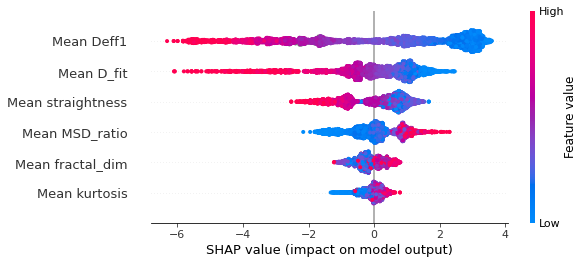

In [137]:
%matplotlib inline


shap.summary_plot(shap_values, X_test[linear_features], max_display=15, title='Total SHAP Values')